In [1]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import joblib

thres_mean_FD = 0.15 # mm
scrub_threshold = 0.15 # mm
thres_perc_scrub = 30 # % scubbed out

# load bochum data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()

In [2]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
#region names
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

In [3]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag

In [4]:
y = df.mean_QST_pain_sensitivity

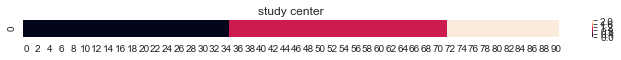

35 37 19


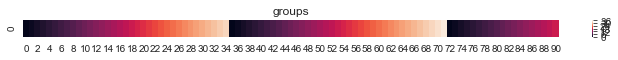

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18])

In [5]:
# create groups to balance-out cross-validations
plt.figure(figsize=(12, 0.3))
sns.heatmap([df.study.astype("category").cat.codes.values]).set_title('study center')
plt.show()
n_szeged = np.sum(df.study == 'szeged') # size of the smallest study
n_essen = np.sum(df.study == 'essen')
n_bochum = np.sum(df.study == 'bochum')
print(n_bochum, n_essen, n_szeged)

groups=np.zeros(len(df), dtype=int)

g=0
i=0
while i < n_bochum:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
    
g=0
i=n_bochum
while i < n_bochum+n_essen:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
g=0
i=n_bochum+n_essen
while i < len(df):
    groups[i] = g
    i += 1
    g += 1
    
plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show()

groups

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2342 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2792 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.4min finished


**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999}
** Score on full data as training set:	-0.003398350521029031
** Score on mean as model: -0.5655535039999882
** Best Non-nested cross-validated score on test:	-0.28246481163282383
XXXXX Explained Variance: 0.5005515665007183


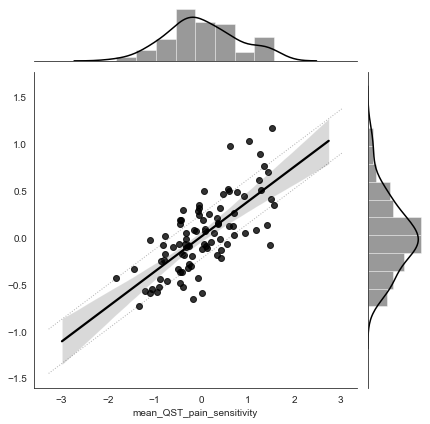

In [6]:
# finalize and save model
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [0.001, 0.01,  0.1, 1],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                 
                        
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

cv = GroupKFold(30)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
clf.fit(X, y, groups=groups)
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print("XXXXX Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))

joblib.dump(clf.best_estimator_, 'model_trained_on_all.joblib')

cv_pred = cross_val_predict(clf.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1)                                 
plot.plot_prediction(y, cv_pred, sd=True, covar=[])

#for train_index, test_index in group_kfold.split(X, y, groups):
#    #print("TRAIN:", train_index, "TEST:", test_index)
#    #print(df.study[train_index].values)
#    print('test:', df.study[test_index].values)



In [13]:
print("** MAE on mean as model: " + str(-mean_absolute_error(np.repeat(y.mean(), len(y)), y)))

** Score on mean as model: -0.6023185209428498


In [7]:
# save NON-nested cv-predictions
np.savetxt("../res/multi-center/nonnested_cv_pred_full_GroupKFold30.csv", cv_pred, delimiter=",")

In [8]:
joblib.dump(clf.best_estimator_, '../res/multi-center/finalized_model_multi-center.joblib')

['../res/multi-center/finalized_model_multi-center.joblib']

# nested cross-validation

model	inner_cv mean score	outer vc score
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2148 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2507 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.6min finished


cv: 0 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.3561685385466687 -0.18031180807008598
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2222 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2581 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.8min finished


cv: 1 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.3757462780234728 -0.0691621142933269
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.2min finished


cv: 2 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.3910878701822796 -0.10071895684776173
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.1min finished


cv: 3 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.27843070234082157 -0.2352956807691747
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.8min finished


cv: 4 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.33516839820229044 -0.10189186402930066
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 2141 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2500 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2950 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 5 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.314070279845082 -0.3952378673295834
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 11.1min finished


cv: 6 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.5} -0.3137721347685468 -0.12473569352687203
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.5min finished


cv: 7 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.35165214793928506 -0.12838291877990013
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1924 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 2238 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2643 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 8 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.5} -0.38671595696914646 -0.05270121853004112
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.5min finished


cv: 9 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.3228851042281764 -0.23854873905342247
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 2026 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2376 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2826 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.5min finished


cv: 10 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.36992782086091053 -0.6129884160808666
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.9min finished


cv: 11 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.5} -0.3495402691287302 -0.8530515664414103
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2148 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2507 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.1min finished


cv: 12 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.3193088040449919 -1.0588121466789895
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.9min finished


cv: 13 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.3142622759792399 -0.5405542456369447
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.0min finished


cv: 14 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.28094426455166666 -0.05471096356794799
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 2022 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2372 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2822 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.7min finished


cv: 15 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.3830239002534183 -0.14583027269355067
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1918 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 2238 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2643 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.7min finished


cv: 16 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.75} -0.31663200655318985 -0.39972606525581317
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.4min finished


cv: 17 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.5} -0.3886687965204453 -0.32722597780262846
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.0min finished


cv: 18 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.3642349258918397 -0.5190256506111455
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.1min finished


cv: 19 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.2887377276010121 -0.4823961045945482
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2181 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2631 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.5min finished


cv: 20 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.32804961956884454 -0.12532041267254385
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.6min finished


cv: 21 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.35276578213292537 -0.42008656818280143
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2047 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 2310 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2712 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.7min finished


cv: 22 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.38548008140605566 -1.0959503786538203
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2661 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.7min finished


cv: 23 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.40217097910650224 -0.48511033325623576
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2511 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2961 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.4min finished


cv: 24 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.75} -0.37877349163508395 -0.044919464341421876
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 2153 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2962 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 25 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.2965428939829529 -0.6698389176664135
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2249 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2654 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 26 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.31109277248833705 -0.21389094599233088
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2377 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2827 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.7min finished


cv: 27 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.37895014541936 -0.23995560511824982
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2218 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2586 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.8min finished


cv: 28 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.25} -0.362455222549256 -0.4550653273012356
Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2249 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2654 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.6min finished


cv: 29 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.31939203055616183 -0.09781906059627446
*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.34388837404255646
** Mean Nested Crossvalidation Score (outer_cv):	-0.3489755094791548
Explained Variance: 0.38294872720095097
Correlation: 0.6094836778212411


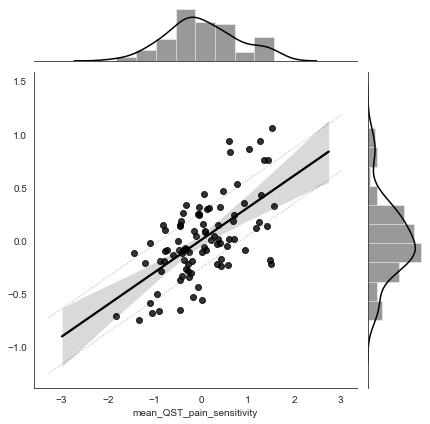

In [9]:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [0.001, 0.01,  0.1, 1],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]
                                 }):
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

outer_cv = GroupKFold(30)
inner_cv = GroupKFold(30)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=groups):
    group_train = groups[train]                                
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1
                                    
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

In [12]:
# save nested predictions
np.savetxt("../res/multi-center/nested_cv_pred_full_GroupKFold30.csv", predicted, delimiter=",")